In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as path
import os
import wget
from tqdm import tqdm
import emcee
import corner

In [2]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/HiggsFitting.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/HiggsFitting.csv'
if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [..............................................................................] 97796 / 97796File loaded


In [3]:
Data = pd.read_csv(Path_)
Data
X = Data.Higgs

In [4]:
def GetHisto(Data,bines):
    
    h, bins = np.histogram(Data,bins=bines)
    w = np.diff(bins)   # Ancho de clase
    m = bins[:-1] + 0.5*w[0] # Marca de clase
    
    hnorm = h/(np.sum(h)*w) # normalizando histo
    
    return h,hnorm,m,w

In [5]:
def Gaus(x,mu=0.,sigma=1.):
    return np.exp( -0.5*( (x - mu)/sigma )**2 )/np.sqrt(2*np.pi*sigma**2)
def Exp(x,alpha=1.):
    return np.exp(-x/alpha)/alpha

In [6]:
def LogPrior(p):
    A, mu, sigma, alpha = p
    if 0. <= A <= 1. and  1. <= mu <= 10. and 0.1 <= sigma <= 5. and 0.5 <= alpha <= 5.:
        return 0.
    else:
        return -np.inf

In [7]:
def Likelihood( p, x, Null=False ):
    
    if Null:
        alpha = p
        L = Exp(x,alpha)
    else:
        A, mu, sigma, alpha = p # A es la normalización de la pdf
        L = A*Gaus(x,mu,sigma) + (1.- A)*Exp(x,alpha)
        
    return L

In [8]:
def JointLikelihood(p,x,Null=False):
    return np.sum(np.log(Likelihood(p,x,Null)))

In [9]:
def LogPosterior(p,x):
    
    LogP = LogPrior(p)
    
    if not np.isfinite(LogP):
        return -np.inf
    else:
        return JointLikelihood(p,x) + LogP # Likelihood + Prior

In [18]:
nll = lambda *p: JointLikelihood(*p)
# The guess
t0 = np.array([0.5, 2., 0.1, 2.])
nll(t0,X,False)

-11463.776729377545

In [19]:
n_walkers, n_params = 10, 4 
p0 = np.zeros((n_walkers,n_params))
p0[:,:] = t0
p0 += np.random.uniform(0,0.2,(n_walkers, n_params)) 
p0

array([[0.65165585, 2.05832236, 0.17883549, 2.1394844 ],
       [0.67487791, 2.12349651, 0.17847423, 2.04950547],
       [0.62828714, 2.16623302, 0.17305347, 2.18708307],
       [0.67388888, 2.05222211, 0.22484105, 2.14817375],
       [0.51606721, 2.08775309, 0.15236308, 2.14682978],
       [0.69761292, 2.16546314, 0.12193951, 2.06677832],
       [0.68351387, 2.12770538, 0.19026096, 2.12572092],
       [0.65677688, 2.03337674, 0.18175152, 2.1926969 ],
       [0.58383338, 2.01117867, 0.29045323, 2.06979793],
       [0.57731525, 2.19733124, 0.13296691, 2.07938502]])

In [20]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, LogPosterior, args=[X])
pos,prob,state = sampler.run_mcmc(p0, 2000, progress = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.43it/s]


Text(0.5, 0, 'step number')

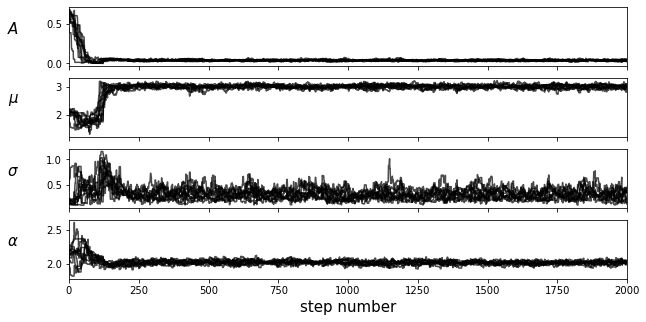

In [21]:
fig, axes = plt.subplots(n_params, figsize=(10, 5), sharex=True)

samples = sampler.get_chain()
labels = [r"$A$",r"$\mu$",r"$\sigma$",r"$\alpha$"]

for i in range(n_params):
    
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.7)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0, fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number",fontsize=15)

In [22]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
truths = np.percentile(pos, 50, axis=0)

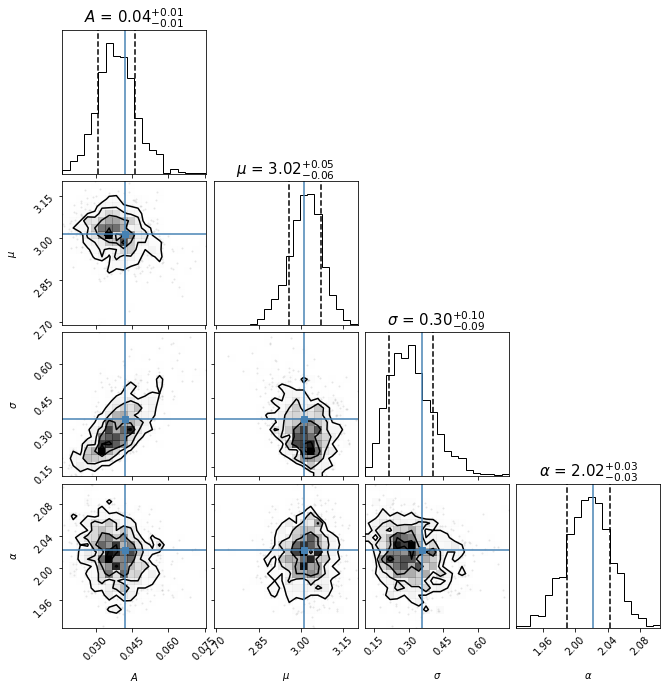

In [23]:
figure = corner.corner(flat_samples, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

In [24]:
xbins = np.linspace(0,10,40)
HSignalBkg, HNSignalBkg, m, w = GetHisto(X,xbins)

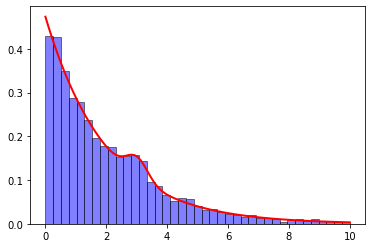

In [25]:
x = np.linspace(xbins[0],xbins[-1],100)
plt.bar(m,HNSignalBkg,width=w,ec='k',color='b',alpha=0.5,label='Data')
plt.plot(x,Likelihood(truths,x),lw=2,color='r',label='Bkg fit component')